# Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
from zipfile import ZipFile
import random 

# DATA

In [3]:
os.getcwd()

'G:\\My Drive\\JOBI\\Data_science\\PUBLICADO\\Statistical_Experiments_and_Significance_Testing'

In [4]:
os.listdir("../../DATA_SET")

['DATA_LAB', 'ab_data.zip', 'diet_anova.zip']

In [6]:
path =  "../../DATA_SET/ab_data.zip"

In [7]:
with ZipFile(path , "r") as zip:
    zip.printdir()
    with zip.open("ab_data.csv") as f:
        data = pd.read_csv(f)

File Name                                             Modified             Size
ab_data.csv                                    2020-08-03 19:50:04     15901933


In [8]:
data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


# Convertion Rate 

**Definition:** The conversion rate is the percentage of users who take a desired action. The archetypical example of conversion rate is the percentage of website visitors who buy something on the site.

To determine a conversion rate, divide the number of goals achieved in a given time frame by the total number of visitors to your website, then multiply that number by 100. So if your landing page had $16,982$ visitors and of those, $3,604$ took a desired action, then your conversion rate is $21.22\%$

For our Dependent Variable (i.e. what we are trying to measure), we are interested in capturing the conversion rate. A way we can code this is by each user session with a binary variable:

* 0 - The user did not buy the product during this user session

* 1 - The user bought the product during this user session

The following permutation procedure asks, “If the two prices share the same conversion rate, could chance variation produce a difference as big as 5%?

In [10]:
data[["group","converted"]].groupby("group").agg(["mean"])

,converted
,mean
group,
control,0.120399
treatment,0.118920


There are $12.0399\%$ and $11.8920\%$ convertion rates for group A and B respectively. The difference is 

In [11]:
obs_pct_diff = (0.120399-0.118920)*100
print(f'Observed difference: {obs_pct_diff:.4f}%')

Observed difference: 0.1479%


less than$1\%$

# Resampling

## Funcion resampling

In [12]:
def perm_fun(x, nA, nB): 
    n = nA + nB 
    idx_B = set(random.sample(range(n), nB)) 
    idx_A = set(range(n)) - idx_B 
    return x.loc[list(idx_B)].mean() - x.loc[list(idx_A)].mean()

## Table

In [13]:
table = pd.DataFrame(
    {
        "outcome":["converted","no converted"],
        "control":[len(data[(data["group"]=="control")&(data["converted"]==1)]),
                  len(data[(data["group"]=="control")&(data["converted"]==0)])],
        "treatment":[len(data[(data["group"]=="treatment")&(data["converted"]==1)]),
                     len(data[(data["group"]=="treatment")&(data["converted"]==0)])]
    }
).set_index("outcome")
#df2 = pd.DataFrame({"control": [len(data[data["group"]=="control"])],
#                    "treatment": [len(data[data["group"]=="treatment"])]},
#                   index=["total"])

#table = pd.concat([df1,df2])

In [15]:
table.loc["Total group"] = table.sum(axis=0)
table["total converted"] = table.sum(axis=1)

## Procedure

In [ ]:
table

,control,treatment,total converted
outcome,,,
converted,17723,17514,35237
no converted,129479,129762,259241
Total group,147202,147276,294478


there are 35237 converted 1 and 259241 no converted 0.

In [17]:
table_conversion = [0]*259241
table_conversion.extend([1]*35237)
table_conversion = pd.Series(table_conversion)

In [31]:
perm_diffs = [100*perm_fun(table_conversion, 147202, 147276) for _ in range(500)]

# Histrogram

In [35]:
print(f'Observed difference in resampling is: {np.mean(perm_diffs):.4f}%')

Observed difference in resampling is: 0.0005%


In [36]:
print(f'Observed difference: {obs_pct_diff:.4f}%')

Observed difference: 0.1479%


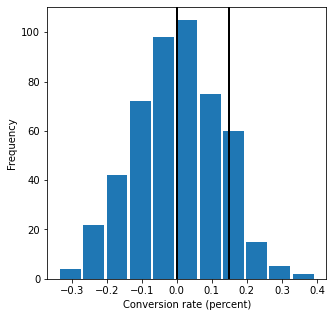

In [34]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9) 
ax.axvline(x=obs_pct_diff, color='black', lw=2) 
ax.axvline(x=np.mean(perm_diffs), color='black', lw=2)
#ax.text(0.06, 200, 'Observed\ndifference', bbox={'facecolor':'white'}) 
ax.set_xlabel('Conversion rate (percent)') 
ax.set_ylabel('Frequency')
plt.show()

# p-values

How often was the difference >= 0.1479%?

In [33]:
np.mean(np.array(perm_diffs)>0.1479)

0.122

shows that mean difference of random permutations exceeds the observed difference (the vertical line) in   $12.2\%$  of the cases

## Using scipy

In [23]:
from scipy import stats

In [32]:
survivors = np.array([[17723, 129479], [17514, 129762]]) 
chi2, p_value, df, _ = stats.chi2_contingency(survivors) 
print(f'p-value for single sided test: {p_value / 2:.4f}')

p-value for single sided test: 0.1091


The normal approximation yields a p-value of $0.1091$, which is close to the p-value obtained from the permutation test

# t-test

## session time in minutes

In [41]:
from datetime import datetime

In [42]:
data["timestamp"] = data["timestamp"].apply(lambda x: x.split(".")[0])
data["timestamp"] = data["timestamp"].apply(lambda x:
                                            datetime.strptime(x,'%Y-%m-%d %H:%M:%S').hour*60+
                                            datetime.strptime(x,'%Y-%m-%d %H:%M:%S').minute
                                            )

In [46]:
data = data.rename(columns={"timestamp":"timestamp_min"})
data.head()

,user_id,timestamp_min,group,landing_page,converted
0,851104,1331,control,old_page,0
1,804228,481,control,old_page,0
2,661590,1015,treatment,new_page,0
3,853541,1108,treatment,new_page,0
4,864975,112,control,old_page,1


## Using scipy

In [50]:
res = stats.ttest_ind(data[data.group == 'control'].timestamp_min,
                      data[data.group == 'treatment'].timestamp_min,
                      equal_var=False)
print(f'p-value for single sided test: {res.pvalue / 2:.4f}')

p-value for single sided test: 0.4184


Remenber that  mean difference of random permutations (resampling procedure) often exceeds the observed difference in session times  $42.2\%$ of the cases (see notebook Resampling), using t-test we get $41.84\%$.